<a id='FEMB'></a>

# Restaurant Fake Review Detection # 3

- __[Feature Engineering](#FE)__
- __[Model Building](#MB)__

    - [Text Analysis (CNN, LSTM)](#TA)

    - [Classification Algorithms](#CA)
    
    
To navigate to each section and subsection, please use this [link]() where you can use embedded internal links within this notebook. 

<a id='FE'></a>

# Feature Engineering

In [1]:
# Import libraries required for analysis

import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from operator import attrgetter
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from textblob import TextBlob

In [2]:
df_join = pd.read_pickle("./org_df.pkl")

In [3]:
# Find out the maximum number of reviews each reviewer has left in a day and drop the reviewerID.

max_temp = df_join.groupby(['reviewerID','date'])['reviewerID'].count().reset_index(name='count')
max_temp_new = max_temp.groupby("reviewerID", as_index = False).max()

df_join = pd.merge(df_join,
                 max_temp_new[['reviewerID', 'count']],
                 on='reviewerID')
df_join.rename({'count': 'maxReview_a_day'}, axis=1, inplace=True)  # rename the count column

In [4]:
# Reviews left by a reviewer whose maxReview_a_day = 12

max_review = df_join.loc[df_join['maxReview_a_day'].idxmax()].reviewerID   
df_join.loc[df_join['reviewerID']==max_review, df_join.columns != 'reviewerID']

,date,reviewContent,rating,flagged,reviewer_location,yelpJoinDate,reviewer_friendCount,reviewer_reviewCount,reviewer_firstCount,reviewer_usefulCount,reviewer_coolCount,reviewer_funnyCount,reviewer_complimentCount,reviewer_tipCount,reviewer_fanCount,restaurant_reviewCount,restaurant_rating,categories,PriceRange,maxReview_a_day
7226,2012-04-12,probably the best meal i have ever had everyth...,5,N,"Chicago, IL",2006-01,8,48,0,7,2,2,0,0,0,841,4.5,"Restaurants, American (New)",Over $61,12
7227,2012-04-12,great atmosphere nice wines try the homemade r...,4,N,"Chicago, IL",2006-01,8,48,0,7,2,2,0,0,0,578,4.0,"Restaurants, Italian",$11-30,12
7228,2012-04-12,very good homemade pasta wonderful outdoor sea...,4,N,"Chicago, IL",2006-01,8,48,0,7,2,2,0,0,0,481,4.0,"Restaurants, Italian",$31-60,12
7229,2012-04-12,their pizza is very good i dont like their atm...,3,N,"Chicago, IL",2006-01,8,48,0,7,2,2,0,0,0,1543,4.0,Other,$11-30,12
7230,2012-04-12,great sandwiches worth the quickly moving line...,4,N,"Chicago, IL",2006-01,8,48,0,7,2,2,0,0,0,1461,4.0,"Restaurants, Mexican",$11-30,12
7231,2012-04-12,my favorite chinese restaurant in chicago best...,4,N,"Chicago, IL",2006-01,8,48,0,7,2,2,0,0,0,607,4.0,"Restaurants, Chinese",$11-30,12
7232,2012-04-12,i started out liking this place much more but ...,3,N,"Chicago, IL",2006-01,8,48,0,7,2,2,0,0,0,947,4.0,Other,$11-30,12
7233,2012-04-12,this place is steady its got a nice fun atmosp...,4,N,"Chicago, IL",2006-01,8,48,0,7,2,2,0,0,0,702,4.0,Other,$31-60,12
7234,2012-04-12,uninspired nice atmosphere and service but the...,3,N,"Chicago, IL",2006-01,8,48,0,7,2,2,0,0,0,581,4.0,"Restaurants, American (New)",Over $61,12
7235,2012-04-12,if you can get over the occasionally terrible ...,4,N,"Chicago, IL",2006-01,8,48,0,7,2,2,0,0,0,684,3.5,Other,$11-30,12


In [5]:
# Calcuate the standard deviation of ratings of each reviewer.

meansd = df_join.groupby(['reviewerID'], as_index=False).agg({'rating':['std']})
meansd.columns = ['reviewerID', 'rating_std']
df_join = pd.merge(df_join, meansd[['reviewerID', 'rating_std']], on='reviewerID')

df_join['rating_std'] = df_join['rating_std'].fillna(0)

In [6]:
# Calculate the time differences between 'date' and 'yelpJoinDate', and remove 'yelpJoinDate' and 'date_mo_yr'. 

df_join['date_mo_yr'] = pd.to_datetime(df_join['date']).dt.to_period('M')
df_join['sinceJoin_months'] = (df_join['date_mo_yr'] - df_join['yelpJoinDate']).apply(attrgetter('n'))

df_join = df_join.drop(['yelpJoinDate', 'date_mo_yr'], axis=1)

In [7]:
# Count the number of words and uppercase letters in each reviewContent.

df_join['wordCount'] = df_join.reviewContent.apply(lambda x: len(x.split()))
df_join['uppercaseCount'] = df_join.reviewContent.apply(lambda x: sum(1 for c in x if c.isupper()))

Most of the reviewers are in Chicago, IL. Rather than having all infrequent location information, create a new column 'reviewer_restaurant_loc_match' to indicate whether reviewers are in Chicago or not as the restaurants in this dataset are in the Chicago area. 

In [8]:
# Rename 'reviewer_location' to 'reviewer_restaurant_loc_match'
df_join.rename(columns = {'reviewer_location':'reviewer_restaurant_loc_match'}, inplace = True)

# Compare reviewer's location & restuarant location (Chicago, IL) and see if they match (Y/N)
for i in range(df_join.shape[0]):
    if df_join.loc[df_join.index[i], 'reviewer_restaurant_loc_match'] == 'Chicago, IL':
        df_join.loc[df_join.index[i], 'reviewer_restaurant_loc_match'] = 'Y'
    else:
        df_join.loc[df_join.index[i], 'reviewer_restaurant_loc_match'] = 'N'

In [9]:
# Create two columns (polarity and subjectivity) using sentiment analysis with review contents.

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

df_join["polarity"] = df_join["reviewContent"].apply(pol)
df_join["subjectivity"] = df_join["reviewContent"].apply(sub)

The 'reviewer_usefulCount', 'reviewer_coolCount', 'reviewer_funnyCount', 'reviewer_complimentCount', 'reviewer_tipCount' have very high correlations with each other. Hence, we create a new feature 'reviewer_upvoteCount' by summing the above features, and drop them to avoid multicolliearity.

In [10]:
# Drop columns to avoid multicolliearity. 

df_join['reviewer_upvoteCount'] = df_join['reviewer_usefulCount'] + df_join['reviewer_coolCount'] + df_join['reviewer_funnyCount'] + df_join['reviewer_complimentCount'] + df_join['reviewer_tipCount']
df_join = df_join.drop(['reviewer_usefulCount', 'reviewer_coolCount', 'reviewer_funnyCount', 'reviewer_complimentCount', 'reviewer_tipCount'], axis=1)

Also, the 'reviewer_fanCount' and 'reviewer_friendCount' have a correlation of 0.89. Both of them represent the number of connections of each reviewer. We keep the 'reviewer_friendCount' and drop the 'reviewer_fanCount'.

In [11]:
# Drop the 'reviewer_fanCount'.

df_join = df_join.drop(['reviewer_fanCount'], axis=1)

In [12]:
# Create 'month', 'day', 'weekday' columns using the 'date' column. 

df_join['month'] = df_join.date.dt.month
df_join['day'] = df_join.date.dt.day
df_join['weekday'] = df_join.date.dt.day_name()

In [13]:
# Lastly, drop 'reviewerID' and 'date'. 

df_join = df_join.drop(['reviewerID', 'date'], axis=1)

In [14]:
# One Hot Encoding (3 attributes)
df_encoded = pd.get_dummies(data=df_join, columns=['categories', 'PriceRange', 'weekday'])



# Label Encoding (1 attribute, 1 class)
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
df_encoded['reviewer_restaurant_loc_match'] = le.fit_transform(df_encoded.reviewer_restaurant_loc_match.values)

le = preprocessing.LabelEncoder()
df_encoded['flagged'] = le.fit_transform(df_encoded.flagged.values)


Now we have 37 attributes including the response with approximately 27,000 reviews. 

In [15]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26956 entries, 0 to 26955
Data columns (total 38 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   reviewContent                            26956 non-null  object 
 1   rating                                   26956 non-null  int64  
 2   flagged                                  26956 non-null  int32  
 3   reviewer_restaurant_loc_match            26956 non-null  int32  
 4   reviewer_friendCount                     26956 non-null  int64  
 5   reviewer_reviewCount                     26956 non-null  int64  
 6   reviewer_firstCount                      26956 non-null  int64  
 7   restaurant_reviewCount                   26956 non-null  int64  
 8   restaurant_rating                        26956 non-null  float64
 9   maxReview_a_day                          26956 non-null  int64  
 10  rating_std                               26956

In [16]:
# Split data into training and test sets.

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


X = df_encoded.drop(['flagged'], axis=1)
Y = df_encoded['flagged'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(20217, 37) (6739, 37) (20217,) (6739,)


In [17]:
# Separate 'reviewContent' from the training and test sets.

X_train_num_cat = X_train.drop('reviewContent', axis=1)
X_train_text = X_train['reviewContent'].copy()

X_test_num_cat = X_test.drop('reviewContent', axis=1)
X_test_text = X_test['reviewContent'].copy()

In [18]:
# Feature scaling (min-max sclaing)

from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame

minmaxscale = MinMaxScaler()

col_names = X_train_num_cat.columns

X_train_num_cat_scaled = minmaxscale.fit_transform(X_train_num_cat)
X_train_num_cat_scaled = DataFrame(X_train_num_cat_scaled, columns = col_names)

X_test_num_cat_scaled = minmaxscale.transform(X_test_num_cat)
X_test_num_cat_scaled = DataFrame(X_test_num_cat_scaled, columns = col_names)

In [19]:
X_train_num_cat_scaled.head()

,rating,reviewer_restaurant_loc_match,reviewer_friendCount,reviewer_reviewCount,reviewer_firstCount,restaurant_reviewCount,restaurant_rating,maxReview_a_day,rating_std,sinceJoin_months,...,PriceRange_$31-60,PriceRange_Over $61,PriceRange_Under $10,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,0.50,0.0,0.002975,0.020307,0.003476,0.268339,0.000000,0.0,0.000000,0.317647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.00,1.0,0.000000,0.005364,0.001159,0.443919,0.333333,0.0,0.000000,0.352941,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.00,1.0,0.001275,0.039847,0.002317,0.191197,0.333333,0.0,0.350382,0.047059,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.75,1.0,0.002125,0.001149,0.000000,0.426881,0.333333,0.0,0.000000,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.75,1.0,0.000000,0.007280,0.002317,0.158069,0.333333,0.0,0.000000,0.564706,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [20]:
X_test_num_cat_scaled.head()

,rating,reviewer_restaurant_loc_match,reviewer_friendCount,reviewer_reviewCount,reviewer_firstCount,restaurant_reviewCount,restaurant_rating,maxReview_a_day,rating_std,sinceJoin_months,...,PriceRange_$31-60,PriceRange_Over $61,PriceRange_Under $10,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,0.75,1.0,0.010625,0.172031,0.022016,0.327970,0.333333,0.090909,0.253546,0.411765,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.00,0.0,0.024012,0.052490,0.030127,0.191197,0.333333,0.000000,0.000000,0.152941,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.00,0.0,0.003612,0.062835,0.013905,0.323237,0.333333,0.000000,0.000000,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.00,1.0,0.000000,0.001916,0.000000,0.287269,0.333333,0.000000,0.000000,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.50,0.0,0.000425,0.005364,0.000000,0.323237,0.333333,0.000000,0.000000,0.011765,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


<a id='MB'></a>

# Model Building

In [21]:
print("Total number of genuine reviews: ", np.count_nonzero(Y == 0), "\nTotal number of fake reviews: ", np.count_nonzero(Y == 1), "\nBaseline model (initial guess) - Accuracy: ", round(np.count_nonzero(Y == 0) / Y.shape[0], 4) * 100, '%')

Total number of genuine reviews:  20750 
Total number of fake reviews:  6206 
Baseline model (initial guess) - Accuracy:  76.98 %


<a id='TA'></a>

## Text Analysis (Natural Language Processing & Deep Learning)

My original idea was to build a classifier using only text data (reviewContent) with Natural Language Processing and Deep Learning techniques, and add the binary outcomes (Fake / Genuine) to the original dataset as a new column, so that I can take into account the raw text data, in addition to the characteristics of text data (word count, polarity score, uppercase letter count, etc). 

Unfortunately, the text classifier is overfitting even after numerous attempts to resolve the problem by dropping out nodes, adjusting embedding size, etc. So the outcome from this classifier will not be used since the results would negatively affect the performance if the new feature is added to the original dataset. 

But I am leaving the code/results in this notebook so I can come back to this later and retry improving it, or get feedbacks from other experts. 

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Embedding, LSTM

# Tokenization - train
docs_train = X_train_text.astype(str).values.tolist()
token = Tokenizer(num_words = 500)
token.fit_on_texts(docs_train)
X_train_seq = token.texts_to_sequences(docs_train)

# Padding (make each list of the same length) - train
padded_X_train = pad_sequences(X_train_seq, 100)

In [23]:
# Tokenization & Padding - test
docs_test = X_test_text.astype(str).values.tolist()
x_test_seq = token.texts_to_sequences(docs_test)
padded_X_test = pad_sequences(x_test_seq, 100) 

Epoch 1/10
203/203 [==============================] - 20s 93ms/step - loss: 0.5130 - accuracy: 0.7666 - val_loss: 0.5127 - val_accuracy: 0.7682
Epoch 2/10
203/203 [==============================] - 19s 95ms/step - loss: 0.4928 - accuracy: 0.7713 - val_loss: 0.5025 - val_accuracy: 0.7664
Epoch 3/10
203/203 [==============================] - 19s 94ms/step - loss: 0.4797 - accuracy: 0.7695 - val_loss: 0.5007 - val_accuracy: 0.7712
Epoch 4/10
203/203 [==============================] - 19s 94ms/step - loss: 0.4716 - accuracy: 0.7751 - val_loss: 0.5098 - val_accuracy: 0.7506
Epoch 5/10
203/203 [==============================] - 19s 94ms/step - loss: 0.4602 - accuracy: 0.7808 - val_loss: 0.4997 - val_accuracy: 0.7709
Epoch 6/10
203/203 [==============================] - 19s 95ms/step - loss: 0.4472 - accuracy: 0.7888 - val_loss: 0.5300 - val_accuracy: 0.7293
Epoch 7/10
203/203 [==============================] - 19s 96ms/step - loss: 0.4198 - accuracy: 0.8042 - val_loss: 0.5523 - val_accuracy:

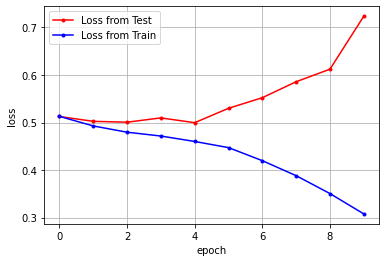

In [24]:
# Using CNN and LSTM
import matplotlib.pyplot as plt
import numpy
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Sequential


model = Sequential()
model.add(Embedding(500, 100))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(300))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

record = model.fit(padded_X_train, Y_train, batch_size=100, epochs=10, validation_data=(padded_X_test, Y_test))
print("\n Accuracy: %.4f" % (model.evaluate(padded_X_test, Y_test)[1]))


Y_val_loss = record.history['val_loss']
Y_loss = record.history['loss']
X_len = numpy.arange(len(Y_loss))
plt.plot(X_len, Y_val_loss, marker='.', c="red", label="Loss from Test")
plt.plot(X_len, Y_loss, marker='.', c="blue", label="Loss from Train")

plt.legend(loc="upper left")
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

<a id='CA'></a>

## Classification Algorithms

For classification problems, there are several metrics in addition to accuracy, which can be used to evaluate classifiers, such as recall and precision.


- Recall = $\frac{TP}{TP + FN}$

- Precision = $\frac{TP}{TP + FP}$


where TP: true positive, FP: false positive, and FN: false negative which can be obtained from confusion matrix. 

The relative importance of recall and precision dependes on situations. In the context of this problem where the goal is to filter out fake reviews and hide them from other users, it would be better to show only genuine reviews even if some of genuine reviews could be filtered out due to classifiers' errors, than failing to filter out fake reviews and letting other users to see them because a single review could bring a negative effect to businesses and customers. In this case, high precision is desired instead of high recall. 

The following is the summary of the classification results based on 10-fold cross validations:

- [XGBoost](#XGB) (Accuracy: 90.5% / Precision: 80.1% / Recall: 77.8%)
- [Random Forest](#RF) (Accuracy: 88.3% / Precision: 78.1% / Recall: 67.8%)
- [Neural Networks](#NN) (Accuracy: 87.3% / Precision: 72.9% / Recall: 70.1%)
- [Logistic Regression](#LR) (Accuracy: 84.9% / Precision: 70.7% / Recall: 58.7%)
- [Support Vector Machine](#SVM) (Accuracy: 82.8% / Precision: 71.2% / Recall: 42.7%)
- [SGD Classifier](#SGD) (Accuracy: 82.5% / Precision: 67.2% / Recall: 46.8%)
- [KNN](#KNN) (Accuracy: 78.0% / Precision: 54.5% / Recall: 27.5%)

The three models that give the best results are selected for hyperparameter tunings to improve the performance. 

In [25]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.ensemble import VotingClassifier

In [26]:
def prec_rec_threshold(precisions, recalls, thresholds):
    """
    Plot precisions and recalls based on thresholds
    """
    
    plt.plot(thresholds, precisions[:-1], 'g--', label="Precision")
    plt.plot(thresholds, recalls[:-1], 'y-', label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])

<a id='XGB'></a>

### XGBoost (Accuracy: 90.5% / Precision: 80.1% / Recall: 77.8%)

In [60]:
# 10-fold Cross Validation

xgb_cl = xgb.XGBClassifier(objective= 'binary:logistic', eval_metric='error', use_label_encoder=False)
xgb_cl.fit(X_train_num_cat_scaled, Y_train)
Y_train_pred = cross_val_predict(xgb_cl, X_train_num_cat_scaled, Y_train, cv=10)

In [61]:
print("Accuracy: ", np.mean(cross_val_score(xgb_cl, X_train_num_cat_scaled, Y_train, cv=10, scoring='accuracy')))
print("Precision: ", precision_score(Y_train, Y_train_pred))
print("Recall: ", recall_score(Y_train, Y_train_pred))

Accuracy:  0.9045353413294924
Precision:  0.8005754758742807
Recall:  0.7785191562634525


In [70]:
# Hyperparameter Tuning (1st)
# Tune 'max_depth' and 'min_child_weight' with wide steps

xgb_cl = xgb.XGBClassifier(learning_rate = 0.1, objective= 'binary:logistic', n_estimators = 180, 
                           scale_pos_weight=1, eval_metric='error', use_label_encoder=False)
param_1 = {
    'max_depth': range(1, 10, 2),
    'min_child_weight' : range(1, 8, 2)
}

grid_search_1 = GridSearchCV(estimator = xgb_cl, param_grid = param_1, scoring = 'accuracy', n_jobs = -1, cv = 5, verbose=True)
grid_search_1.fit(X_train_num_cat_scaled, Y_train)
grid_search_1.best_params_, grid_search_1.best_score_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


({'max_depth': 5, 'min_child_weight': 3}, 0.9055745077704488)

In [71]:
# Hyperparameter Tuning (2nd)
# Tune 'max_depth' and 'min_child_weight' with small steps

xgb_cl = xgb.XGBClassifier(learning_rate = 0.1, objective= 'binary:logistic', n_estimators = 180, 
                           scale_pos_weight=1, eval_metric='error', use_label_encoder=False)
param_2 = {
    'max_depth': [4,5,6],
    'min_child_weight' : [2,3,4]
}

grid_search_2 = GridSearchCV(estimator = xgb_cl, param_grid = param_2, scoring = 'accuracy', n_jobs = -1, cv = 5, verbose=True)
grid_search_2.fit(X_train_num_cat_scaled, Y_train)
grid_search_2.best_params_, grid_search_2.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


({'max_depth': 5, 'min_child_weight': 2}, 0.9060196727904992)

In [73]:
# Hyperparameter Tuning (3rd)
# Tune 'gamma' 

xgb_cl = xgb.XGBClassifier(max_depth = 5, min_child_weight = 2, 
                           learning_rate = 0.1, objective= 'binary:logistic', n_estimators = 180, 
                           scale_pos_weight=1, eval_metric='error', use_label_encoder=False)
param_3 = {
    'gamma' : [0.0, 0.1, 0.2, 0.3, 0.4]
}

grid_search_3 = GridSearchCV(estimator = xgb_cl, param_grid = param_3, scoring = 'accuracy', n_jobs = -1, cv = 5, verbose=True)
grid_search_3.fit(X_train_num_cat_scaled, Y_train)
grid_search_3.best_params_, grid_search_3.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


({'gamma': 0.0}, 0.9060196727904992)

In [77]:
# Hyperparameter Tuning (4th)
# Tune 'subsample' and 'colsample_bytree'

xgb_cl = xgb.XGBClassifier(gamma = 0.0, max_depth = 5, min_child_weight = 2, 
                           learning_rate = 0.1, objective= 'binary:logistic', n_estimators = 180, 
                           scale_pos_weight=1, eval_metric='error', use_label_encoder=False)
param_4 = {
    'subsample' : [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree' : [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

grid_search_4 = GridSearchCV(estimator = xgb_cl, param_grid = param_4, scoring = 'accuracy', n_jobs = -1, cv = 5, verbose=True)
grid_search_4.fit(X_train_num_cat_scaled, Y_train)
grid_search_4.best_params_, grid_search_4.best_score_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


({'colsample_bytree': 0.5, 'subsample': 1.0}, 0.9064153084313953)

In [80]:
# Hyperparameter Tuning (5th)
# Tune 'subsample' and 'colsample_bytree' 

xgb_cl = xgb.XGBClassifier(colsample_bytree = 0.5, subsample = 1.0, gamma = 0.0, max_depth = 5, min_child_weight = 2, 
                           objective= 'binary:logistic',  
                           scale_pos_weight=1, eval_metric='error', use_label_encoder=False)
param_5 = {
    'n_estimators' : [160, 170, 180, 190, 200],
    'learning_rate' : [0.01, 0.05, 0.1, 0.15, 0.3]
}

grid_search_5 = GridSearchCV(estimator = xgb_cl, param_grid = param_5, scoring = 'accuracy', n_jobs = -1, cv = 5, verbose=True)
grid_search_5.fit(X_train_num_cat_scaled, Y_train)
grid_search_5.best_params_, grid_search_5.best_score_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


({'learning_rate': 0.15, 'n_estimators': 180}, 0.9082950395024018)

In [81]:
# Hyperparameter Tuning (6th)
# Tune 'subsample' and 'colsample_bytree' 

xgb_cl = xgb.XGBClassifier(colsample_bytree = 0.5, subsample = 1.0, gamma = 0.0, max_depth = 5, min_child_weight = 2, 
                           objective= 'binary:logistic',  
                           scale_pos_weight=1, eval_metric='error', use_label_encoder=False)
param_6 = {
    'n_estimators' : [170, 175, 180],
    'learning_rate' : [0.13, 0.14, 0.15, 0.16, 0.17]
}

grid_search_6 = GridSearchCV(estimator = xgb_cl, param_grid = param_6, scoring = 'accuracy', n_jobs = -1, cv = 5, verbose=True)
grid_search_6.fit(X_train_num_cat_scaled, Y_train)
grid_search_6.best_params_, grid_search_6.best_score_

Fitting 5 folds for each of 15 candidates, totalling 75 fits


({'learning_rate': 0.17, 'n_estimators': 170}, 0.9083940615632201)

In [82]:
# 10-fold Cross Validation with tuned hyperparameters 

xgb_cl = xgb.XGBClassifier(learning_rate = 0.17, n_estimators = 170, colsample_bytree = 0.5, 
                           subsample = 1.0, gamma = 0.0, max_depth = 5, min_child_weight = 2, objective= 'binary:logistic',  
                           scale_pos_weight=1, eval_metric='error', use_label_encoder=False)
xgb_cl.fit(X_train_num_cat_scaled, Y_train)
Y_train_pred = cross_val_predict(xgb_cl, X_train_num_cat_scaled, Y_train, cv=10)

In [83]:
print("Accuracy: ", np.mean(cross_val_score(xgb_cl, X_train_num_cat_scaled, Y_train, cv=10, scoring='accuracy')))
print("Precision: ", precision_score(Y_train, Y_train_pred))
print("Recall: ", recall_score(Y_train, Y_train_pred))

Accuracy:  0.9082450295634708
Precision:  0.8094921268573964
Recall:  0.785622040464916


Although all metrics (accuracy, precision, and recall) have increased after hyperparameter tuning, it is not a huge improvement. 

Source: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

<a id='RF'></a>

### Random Forest (Accuracy: 88.3% / Precision: 78.1% / Recall: 67.8%)

In [87]:
# 10-fold Cross Validation

rnd_cl = RandomForestClassifier(n_estimators=300, max_leaf_nodes=20, n_jobs=-1, oob_score=True, max_features = "auto")
rnd_cl.fit(X_train_num_cat_scaled, Y_train)
Y_train_pred = cross_val_predict(rnd_cl, X_train_num_cat_scaled, Y_train, cv=10)

In [88]:
print("Accuracy: ", np.mean(cross_val_score(rnd_cl, X_train_num_cat_scaled, Y_train, cv=10, scoring='accuracy')))
print("Precision: ", precision_score(Y_train, Y_train_pred))
print("Recall: ", recall_score(Y_train, Y_train_pred))

Accuracy:  0.8822774811071289
Precision:  0.7842551071250623
Recall:  0.6775721050365906


In [100]:
# Hyperparameter Tuning (1st)

rnd_cl = RandomForestClassifier(n_jobs=-1, oob_score=True)
random_param = {'n_estimators': range(200, 1000, 100),
               'max_depth': range(10, 100, 10),
               'min_samples_split': range(2,10,1),
               'min_samples_leaf': range(1,5,1)}

random_search1 = RandomizedSearchCV(estimator = rnd_cl, param_distributions = random_param, 
                               n_iter = 100, cv = 5, verbose=2, n_jobs = -1)
random_search1.fit(X_train_num_cat_scaled, Y_train)
random_search1.best_params_, random_search1.best_score_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


({'n_estimators': 700,
  'min_samples_split': 2,
  'min_samples_leaf': 1,
  'max_depth': 50},
 0.8960775643044003)

In [101]:
# Hyperparameter Tuning (2nd)
# Tune 'max_depth' and 'n_estimators' with small steps

rnd_cl = RandomForestClassifier(min_samples_split = 2, min_samples_leaf = 1, 
                                n_jobs=-1, oob_score=True, max_features = "auto")

param_2 = {
    'n_estimators' : range(650, 750, 10),
    'max_depth' : [45, 50, 55]
}

grid_search_2 = GridSearchCV(estimator = rnd_cl, param_grid = param_2, scoring = 'accuracy', n_jobs = -1, cv = 5, verbose=True)
grid_search_2.fit(X_train_num_cat_scaled, Y_train)
grid_search_2.best_params_, grid_search_2.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


({'max_depth': 45, 'n_estimators': 670}, 0.8961270936835545)

In [102]:
# 10-fold Cross Validation with tuned hyperparameters 

rnd_cl = RandomForestClassifier(max_depth = 45, n_estimators = 670, min_samples_split = 2, min_samples_leaf = 1, 
                                n_jobs=-1, oob_score=True, max_features = "auto")
rnd_cl.fit(X_train_num_cat_scaled, Y_train)
Y_train_pred = cross_val_predict(rnd_cl, X_train_num_cat_scaled, Y_train, cv=10)

In [103]:
print("Accuracy: ", np.mean(cross_val_score(rnd_cl, X_train_num_cat_scaled, Y_train, cv=10, scoring='accuracy')))
print("Precision: ", precision_score(Y_train, Y_train_pred))
print("Recall: ", recall_score(Y_train, Y_train_pred))

Accuracy:  0.8960280800359822
Precision:  0.7939267501159017
Recall:  0.7371932845458459


<a id='NN'></a>

### Neural Networks (Accuracy: 87.3% / Precision: 72.9% / Recall: 70.1%)

In [31]:
n_features = X_test_num_cat.shape[1]

def create_network():
    model = Sequential()
    model.add(Dense(20, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
    model.add(Dense(10, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(1, activation='sigmoid'))
    # compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [32]:
neural_network = KerasClassifier(build_fn=create_network, 
                                 epochs=100, 
                                 batch_size=32, 
                                 verbose=0)

np.mean(cross_val_score(neural_network, X_train_num_cat_scaled, Y_train, cv=10, scoring='accuracy'))

C:\Users\sjung\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
C:\Users\sjung\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if

0.8748570523841896

In [33]:
Y_train_pred = cross_val_predict(neural_network, X_train_num_cat_scaled, Y_train, cv=10)
print(precision_score(Y_train, Y_train_pred), recall_score(Y_train, Y_train_pred))

C:\Users\sjung\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
C:\Users\sjung\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if

0.7420918956361118 0.6917778734395179


C:\Users\sjung\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [34]:
model = Sequential()
model.add(Dense(20, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(10, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# fit the model
model.fit(X_train_num_cat_scaled, Y_train, epochs=200, batch_size=32, verbose=1)

Epoch 1/200
632/632 [==============================] - 1s 477us/step - loss: 0.5072 - accuracy: 0.7616
Epoch 2/200
632/632 [==============================] - 0s 488us/step - loss: 0.3815 - accuracy: 0.8247
Epoch 3/200
632/632 [==============================] - 0s 489us/step - loss: 0.3630 - accuracy: 0.8380
Epoch 4/200
632/632 [==============================] - 0s 564us/step - loss: 0.3528 - accuracy: 0.8435
Epoch 5/200
632/632 [==============================] - 0s 586us/step - loss: 0.3440 - accuracy: 0.8449
Epoch 6/200
632/632 [==============================] - 0s 591us/step - loss: 0.3344 - accuracy: 0.8467
Epoch 7/200
632/632 [==============================] - 0s 560us/step - loss: 0.3261 - accuracy: 0.8503
Epoch 8/200
632/632 [==============================] - 0s 602us/step - loss: 0.3173 - accuracy: 0.8556
Epoch 9/200
632/632 [==============================] - 0s 605us/step - loss: 0.3096 - accuracy: 0.8595
Epoch 10/200
632/632 [==============================] - 0s 564us/step - l

632/632 [==============================] - 0s 558us/step - loss: 0.2406 - accuracy: 0.8935
Epoch 158/200
632/632 [==============================] - 0s 557us/step - loss: 0.2417 - accuracy: 0.8904
Epoch 159/200
632/632 [==============================] - 0s 575us/step - loss: 0.2409 - accuracy: 0.8927
Epoch 160/200
632/632 [==============================] - 0s 621us/step - loss: 0.2395 - accuracy: 0.8938
Epoch 161/200
632/632 [==============================] - 0s 590us/step - loss: 0.2404 - accuracy: 0.8933
Epoch 162/200
632/632 [==============================] - 0s 542us/step - loss: 0.2400 - accuracy: 0.8914
Epoch 163/200
632/632 [==============================] - 0s 549us/step - loss: 0.2395 - accuracy: 0.8926
Epoch 164/200
632/632 [==============================] - 0s 546us/step - loss: 0.2400 - accuracy: 0.8917
Epoch 165/200
632/632 [==============================] - 0s 606us/step - loss: 0.2388 - accuracy: 0.8930
Epoch 166/200
632/632 [==============================] - 0s 539us/ste

In [35]:
"""n_features = X_test_num_cat_scaled.shape[1]
model = Sequential()
model.add(Dense(20, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(10, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# fit the model
model.fit(X_train_num_cat_scaled, Y_train, epochs=200, batch_size=32, verbose=1)

print("\n Accuracy: %.4f" % (model.evaluate(X_test_num_cat_scaled, Y_test)))


# evaluate the model
#loss, acc = model.evaluate(X_test, Y_test, verbose=0)
#print('Test Accuracy: %.3f' % acc)"""

'n_features = X_test_num_cat_scaled.shape[1]\nmodel = Sequential()\nmodel.add(Dense(20, activation=\'relu\', kernel_initializer=\'he_normal\', input_shape=(n_features,)))\nmodel.add(Dense(10, activation=\'relu\', kernel_initializer=\'he_normal\'))\nmodel.add(Dense(8, activation=\'relu\', kernel_initializer=\'he_normal\'))\nmodel.add(Dense(1, activation=\'sigmoid\'))\n# compile the model\nmodel.compile(optimizer=\'adam\', loss=\'binary_crossentropy\', metrics=[\'accuracy\'])\n# fit the model\nmodel.fit(X_train_num_cat_scaled, Y_train, epochs=200, batch_size=32, verbose=1)\n\nprint("\n Accuracy: %.4f" % (model.evaluate(X_test_num_cat_scaled, Y_test)))\n\n\n# evaluate the model\n#loss, acc = model.evaluate(X_test, Y_test, verbose=0)\n#print(\'Test Accuracy: %.3f\' % acc)'

<a id='LR'></a>

### Logistic Regression CV (Accuracy: 84.9% / Precision: 70.7% / Recall: 58.7%)

In [36]:
# 10-fold Cross Validation

log_cl = LogisticRegression(solver="lbfgs", C=10, max_iter=400, random_state=0)
log_cl.fit(X_train_num_cat_scaled, Y_train)
np.mean(cross_val_score(log_cl, X_train_num_cat_scaled, Y_train, cv=10, scoring='accuracy'))

0.8493349259090138

In [37]:
Y_train_pred = cross_val_predict(log_cl, X_train_num_cat_scaled, Y_train, cv=10)
print(precision_score(Y_train, Y_train_pred), recall_score(Y_train, Y_train_pred))

0.7074688796680498 0.5871717606543263


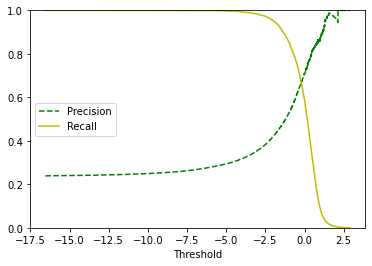

In [38]:
# Precision vs. Recall based on thresholds

Y_log_scores = cross_val_predict(log_cl, X_train_num_cat_scaled, Y_train, cv=10, method='decision_function')
precisions_log, recalls_log, thresholds_log = precision_recall_curve(Y_train, Y_log_scores)
prec_rec_threshold(precisions_log, recalls_log, thresholds_log)
plt.show()

In [39]:
"""TEST (SCALED)

softmax_reg = LogisticRegression(solver="lbfgs", C=10, max_iter=3000, random_state=0)
softmax_reg.fit(X_train_num_cat_scaled, Y_train)

print(softmax_reg.score(X_train_num_cat_scaled, Y_train))   # train error
print(softmax_reg.score(X_test_num_cat_scaled, Y_test))     # test error

predictions = softmax_reg.predict(X_test_num_cat_scaled)
print(classification_report(Y_test, predictions))

"""

'TEST (SCALED)\n\nsoftmax_reg = LogisticRegression(solver="lbfgs", C=10, max_iter=3000, random_state=0)\nsoftmax_reg.fit(X_train_num_cat_scaled, Y_train)\n\nprint(softmax_reg.score(X_train_num_cat_scaled, Y_train))   # train error\nprint(softmax_reg.score(X_test_num_cat_scaled, Y_test))     # test error\n\npredictions = softmax_reg.predict(X_test_num_cat_scaled)\nprint(classification_report(Y_test, predictions))\n\n'

In [40]:
"""Grid search / TEST (SCALED)


from sklearn.model_selection import GridSearchCV


params = {'C':[1, 5, 10, 15, 50, 100], 'tol': [0.001, 0.0001, 0.005]}
log_reg = LogisticRegression(solver='lbfgs', max_iter=500, penalty='l2')
clf = GridSearchCV(log_reg, params, refit='True', n_jobs=1, verbose=3, cv=5)
clf.fit(X_train, Y_train)

print(clf.score(X_train, Y_train))   # train error
print(clf.score(X_test, Y_test))     # test error

predictions = clf.predict(X_test)
print(classification_report(Y_test, predictions))

print(clf.best_params_)

"""

"Grid search / TEST (SCALED)\n\n\nfrom sklearn.model_selection import GridSearchCV\n\n\nparams = {'C':[1, 5, 10, 15, 50, 100], 'tol': [0.001, 0.0001, 0.005]}\nlog_reg = LogisticRegression(solver='lbfgs', max_iter=500, penalty='l2')\nclf = GridSearchCV(log_reg, params, refit='True', n_jobs=1, verbose=3, cv=5)\nclf.fit(X_train, Y_train)\n\nprint(clf.score(X_train, Y_train))   # train error\nprint(clf.score(X_test, Y_test))     # test error\n\npredictions = clf.predict(X_test)\nprint(classification_report(Y_test, predictions))\n\nprint(clf.best_params_)\n\n"

<a id='SVM'></a>

### Support Vector Machine (Accuracy: 82.8% / Precision: 71.2% / Recall: 42.7%)

- When the SVM model is overfitting, we can decrease C (the lower the C, the wider the margin and the larger the margin violation or error) to control the model. 

- 사실 대부분의 마진 오류 (margin violation - 즉, 샘플이 도로 중간이나 심지어 반대쪽에 있는 경우)은 결정 경계를 기준으로 올바른 클래스로 분류되기 때문에 보통 훈련 세트에서 예측 에러는 마진 오류보다 작다

- 다항식 특성을 추가하는 것은 간단하고 (SVM 뿐만 아니라) 모든 머신러닝 알고리즘에서 잘 작동합니다. 하지만 낮은차수의 다항식은 매우 복잡한 데이터셋을 잘 표현하지 못하고 높은 차수의 다항식은 굉장히 많은 특성을 추가하므로 모델을 느리게 만듭니다. 

- 다행히도 SVM 을 사용할 땐 kernel trick 이라는 거의 기적에 가까운 수학적 기교를 적용할 수 있습니다. 실제로는 특성을 추가하지 않으면서 다항식 특성을 많이 추가한 것과 같은 결과 얻을 수 있습니다. => 사실 어떤 특성도 추가하지 않기 때문에 엄청난 수의 특성 조합이 생기지 않습니다.  

- coef0: 모델이 높은 차수와 낮은 차수에 얼마나 영향을 받을지 조절 (기본값: 0)

    - 다항식 커널은 차수가 높아질수록 1보다 작은 값과 1보다 큰 값의 차이가 크게 벌이지므로 coef0을 적절한 값으로 지정하면 고차항의 영향을 줄일 수 있음. 
    
- gamma: gamma를 증가시키면 종 모양 그래프가 좁아져서 각 샘플의 영향 범위가 작아짐. 결정경계가 조금 더 불규칙해지고 각 샘플을 따라 구불구불하게 휘어짐. 작은 gamma 값은 종 모양 그래프를 만들며 샘플이 넓은 범위에 걸쳐 영향을 주므로 결정 경계가 더 부드러워짐
    - 결국 하이퍼파라미터 gamma가 규제의 역할을 함. 모델이 과대적합을 경우엔 감소시켜야 하고 과소적합일 경우엔 증가시켜야 함 (C와 비슷)

- 여러 가지 커널 중 어떤 것을 사용해야 할까? 경험적으로 봤을 때 언제나 선형 커널을 가장 먼저 시도해봐야됨. (LinearSVC가 SVC(kernel="linear") 보다 훨씬 빠름을 기억). 특히 훈련 세트가 아주 크거나 특성 수가 많을 때 더욱 그럼. 훈련 세트가 너무 크지 않다면 가우시안 rfb 커널을 시도해보면 좋음. 대부분의 경우 이 커널이 잘 들어맞음. 시간과 컴퓨팅 성능이 충분하다면 (특히 훈련 데이터의 구조에 특화된 커널이 있는 경우) 교차 검증과 그리드 탐색을 사용해 다른 커널을 좀 더 시도해볼 수 있음. 

In [41]:
# 10-fold Cross validation

svm_cl=SVC(random_state=1, coef0=0, C=1, gamma= 'scale', kernel='rbf', decision_function_shape='ovo')
svm_cl.fit(X_train_num_cat_scaled, Y_train)
np.mean(cross_val_score(svm_cl, X_train_num_cat_scaled, Y_train, cv=10, scoring='accuracy'))

0.8285104816831772

In [42]:
Y_train_pred = cross_val_predict(svm_cl, X_train_num_cat_scaled, Y_train, cv=10)
print(precision_score(Y_train, Y_train_pred), recall_score(Y_train, Y_train_pred))

0.711669658886894 0.4266035299182092


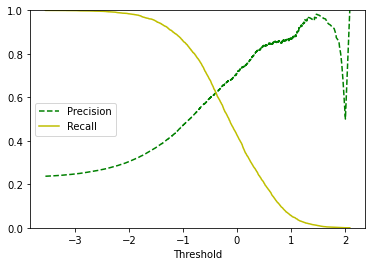

In [43]:
# Precision vs. Recall based on thresholds

Y_svm_scores = cross_val_predict(svm_cl, X_train_num_cat_scaled, Y_train, cv=10, method='decision_function')
precisions_svm, recalls_svm, thresholds_svm = precision_recall_curve(Y_train, Y_svm_scores)
prec_rec_threshold(precisions_svm, recalls_svm, thresholds_svm)
plt.show()

<a id='SGD'></a>

### SGD Classifier (Accuracy: 82.5% / Precision: 67.2% / Recall: 46.8%) 

In [44]:
sgd_cl = SGDClassifier(max_iter=50, random_state=42)
sgd_cl.fit(X_train_num_cat_scaled, Y_train)

np.mean(cross_val_score(sgd_cl, X_train_num_cat_scaled, Y_train, cv=10, scoring='accuracy'))

0.8251976159328045

In [45]:
Y_train_pred = cross_val_predict(sgd_cl, X_train_num_cat_scaled, Y_train, cv=10)
print(precision_score(Y_train, Y_train_pred), recall_score(Y_train, Y_train_pred))

0.6717109326744904 0.4681446405510116


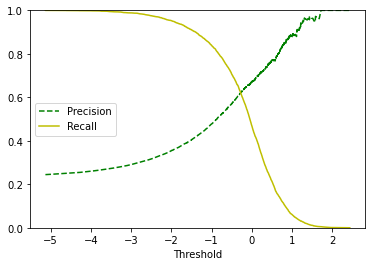

In [46]:
# Precision vs. Recall based on thresholds

Y_sgd_scores = cross_val_predict(sgd_cl, X_train_num_cat_scaled, Y_train, cv=10, method='decision_function')
precisions_sgd, recalls_sgd, thresholds_sgd = precision_recall_curve(Y_train, Y_sgd_scores)

prec_rec_threshold(precisions_sgd, recalls_sgd, thresholds_sgd)
plt.show()

In [48]:
"""# In order to increase the precision and allow a decrease in the recall, set the threshold greater than 0.5.
# This will give the precision greater than 0.77

Y_train_pred_90 = (Y_scores > 0.5)
print(precision_score(Y_train, Y_train_pred_90), recall_score(Y_train, Y_train_pred_90))"""

'# In order to increase the precision and allow a decrease in the recall, set the threshold greater than 0.5.\n# This will give the precision greater than 0.77\n\nY_train_pred_90 = (Y_scores > 0.5)\nprint(precision_score(Y_train, Y_train_pred_90), recall_score(Y_train, Y_train_pred_90))'

<a id='KNN'></a>

### KNN (Accuracy: 78.0% / Precision: 54.5% / Recall: 27.5%)

In [49]:
knn_cl = KNeighborsClassifier(n_neighbors=9)
knn_cl.fit(X_train_num_cat_scaled, Y_train)
np.mean(cross_val_score(knn_cl, X_train_num_cat_scaled, Y_train, cv=10, scoring='accuracy'))

0.7806793260282368

In [50]:
Y_train_pred = cross_val_predict(knn_cl, X_train_num_cat_scaled, Y_train, cv=10)
print(precision_score(Y_train, Y_train_pred), recall_score(Y_train, Y_train_pred))

0.5452604611443211 0.2748600947051227


### Soft Voting (Scaled: 87.6%)

In [ ]:
# Soft Voting (logistic regression, random forest, support vector machine)

xgb_cl = xgb.XGBClassifier(eval_metric='error', use_label_encoder=False)
log_cl = LogisticRegression(solver="lbfgs", C=10, max_iter=3000)
#rnd_clf = RandomForestClassifier(n_estimators=300, max_leaf_nodes=20, n_jobs=-1, oob_score=True)
svm_cl = SVC(random_state=1, coef0=0, C=1, gamma= 'scale', kernel='rbf', decision_function_shape='ovo', probability=True)

voting_cl = VotingClassifier(estimators = [('lr', log_cl), ('xgb', xgb_cl), ('svc', svm_cl)], voting='soft')
voting_cl.fit(X_train_num_cat_scaled, Y_train)


for clf in (log_cl, xgb_cl, svm_cl, voting_cl):
    clf.fit(X_train_num_cat_scaled, Y_train)
    Y_pred = clf.predict(X_test_num_cat_scaled)
    print(clf.__class__.__name__, accuracy_score(Y_test, Y_pred))

In [ ]:
Y_train_pred = cross_val_predict(voting_cl, X_train_num_cat_scaled, Y_train, cv=10)
print(precision_score(Y_train, Y_train_pred), recall_score(Y_train, Y_train_pred))

In [85]:
# Soft Voting (logistic regression, random forest, support vector machine)

xgb_cl = xgb.XGBClassifier(eval_metric='error', use_label_encoder=False)
rnd_cl = RandomForestClassifier(n_estimators=300, max_leaf_nodes=20, n_jobs=-1, oob_score=True)
svm_cl = SVC(random_state=1, coef0=0, C=1, gamma= 'scale', kernel='rbf', decision_function_shape='ovo', probability=True)

voting_cl = VotingClassifier(estimators = [('rnd', rnd_cl), ('xgb', xgb_cl), ('svc', svm_cl)], voting='soft')
voting_cl.fit(X_train_num_cat_scaled, Y_train)


for clf in (rnd_cl, xgb_cl, svm_cl, voting_cl):
    clf.fit(X_train_num_cat_scaled, Y_train)
    Y_pred = clf.predict(X_test_num_cat_scaled)
    print(clf.__class__.__name__, accuracy_score(Y_test, Y_pred))

ValueError: The estimator Sequential should be a classifier.